# The following notebook includes:
* Was used dataset from the article (ready csv file)
* Used feature importance and PCA for vizualization
* Tried MLP network from the article
* Tried other ML algorithms with tuning parameters

In [1]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.learning_curve import validation_curve

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

/Users/alexparub/Packages/miniconda3/envs/jupyter3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/alexparub/Packages/miniconda3/envs/jupyter3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
new_data = pd.read_csv('voice.csv', sep=',\s*', skip_footer=2).reset_index()

vals = []
for index, value in enumerate(new_data.level_0.values):
    vals.append(float(value[1:]))
new_data[['level_0']] = vals

columns = ["meanfreq","sd","median","Q25","Q75","IQR","skew","kurt","sp.ent","sfm",
           "mode","centroid","meanfun","minfun","maxfun","meandom","mindom","maxdom","dfrange","modindx","label"]

new_data.columns = columns

male = new_data.label[0]
new_data.label = (new_data.label == male).astype(np.int8)

In [3]:
new_data.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,...,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,...,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752,0.500000
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,...,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454,0.500079
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,...,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,...,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766,0.000000
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,...,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357,0.500000
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,...,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183,1.000000
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,...,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374,1.000000


In [4]:
X = new_data.drop('label', axis=1)
y = new_data.label

In [5]:
#check if their dataset is balanced
print ('Number male samples is',sum(y == 1))
print ('Number female samples is',sum(y == 0))

Number male samples is 1584
Number female samples is 1584


##### Neural network from the article

In [6]:
state = np.random.get_state()
np.random.seed(42)
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Nadam

y = to_categorical(y, 2)
x_input = Input(shape=(20,))

hidden1 = Dense(units=64, activation='tanh')(x_input)
hidden1 = Dropout(0.25)(hidden1)
hidden2 = Dense(units=256, activation='tanh')(hidden1)
hidden2 = Dropout(0.25)(hidden2)
hidden3 = Dense(units=256, activation='tanh')(hidden2)
hidden3 = Dropout(0.25)(hidden3)
hidden4 = Dense(units=64, activation='tanh')(hidden3)

y_output = Dense(units=2, activation='softmax')(hidden4)

model = Model(inputs=x_input, outputs=y_output)
model.compile(loss='kullback_leibler_divergence', optimizer=Nadam(lr=1e-3), metrics=['accuracy'])

Using TensorFlow backend.


In [7]:
kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs = 150
batch_size = 32

scores = []
for train, test in kFold.split(X, y[:, 0]):
    model.fit(X.values[train], y[train], 
              validation_data=(X.values[test], y[test]), 
              epochs=epochs, batch_size=batch_size, verbose=0)
    score = model.evaluate(X.values[test], y[test], verbose=0)
    print('Accuracy: {:.3f}'.format(score[1]))
    scores.append(score[1])
print('Neural network: {:.3f}±{:.3f}'.format(np.mean(scores), np.std(scores)))
np.random.set_state(state)

Accuracy: 0.954
Accuracy: 0.968
Accuracy: 0.970
Accuracy: 0.979
Accuracy: 0.959
Neural network: 0.966±0.009


##### Looking at efficiency of ML methods on 5-fold cross-validation

In [8]:
X = new_data.drop('label', axis=1)
y = new_data.label
def cross_val_model(model, X, y, verbose=2):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, verbose=verbose, scoring='accuracy')
    print('{}: {:.3f}±{:.3f}'.format(model.__class__.__name__, np.mean(scores), np.std(scores)))

In [9]:
boost = GradientBoostingClassifier(random_state = 42)
cross_val_model(boost, X, y, 0)

GradientBoostingClassifier: 0.957±0.017


In [10]:
forest = RandomForestClassifier(random_state = 42)
cross_val_model(forest, X, y, 0)

RandomForestClassifier: 0.928±0.066


In [11]:
svm = SVC(random_state = 42, probability=True)
cross_val_model(svm, X, y, 0)

SVC: 0.475±0.099


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
#stacked model
forest.fit(X_train, y_train)
svm.fit(X_train, y_train)
boost.fit(X_train, y_train)
combo = pd.DataFrame({'forest': forest.predict_proba(X_test)[:, 1], 
                      'svm': svm.predict_proba(X_test)[:, 1], 
                      'boost': boost.predict_proba(X_test)[:, 1]})
cross_val_model(boost, combo, y_test, 0)

GradientBoostingClassifier: 0.974±0.014


##### Feature importance

Features by importance: 
['meanfun' 'Q25' 'IQR' 'sd' 'sp.ent' 'meanfreq' 'skew' 'sfm' 'median'
 'centroid' 'Q75' 'modindx' 'minfun' 'maxdom' 'kurt' 'dfrange' 'maxfun'
 'meandom' 'mindom' 'mode']


<BarContainer object of 20 artists>

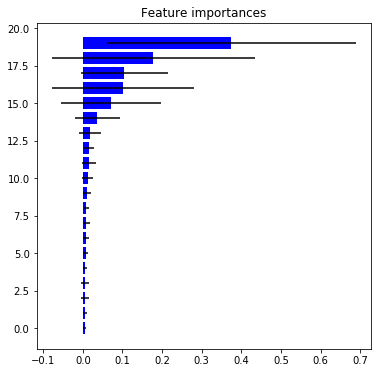

In [14]:
fig, ax = plt.subplots(1, figsize=(6, 6))

indices = np.argsort(forest.feature_importances_)
print('Features by importance: \n{}'.format(X.columns[indices[::-1]].values))
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

ax.set_title("Feature importances")
ax.barh(range(X.shape[1]), forest.feature_importances_[indices], color="b", 
        xerr=std[indices], align="center")

##### We see, that the most important feature is mean fundamental frequency, here is its distribution, we see 2 gaussians

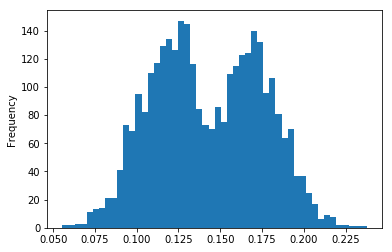

In [15]:
fig, ax = plt.subplots(1)
ax = new_data.meanfun.plot.hist(bins=50)
fig.savefig('histnn.png')

##### Males and female are somehow separable in real life by voice via of fundamental frequency, so here we actually see on point around 0.150 kHz there could be separability

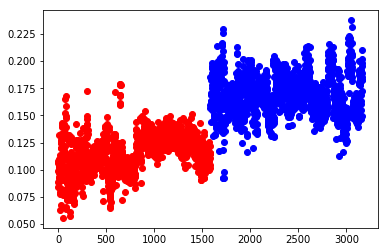

In [16]:
fig, ax = plt.subplots(1)

ax.plot(np.arange(np.sum(new_data.label == 1)), new_data.meanfun[new_data.label == 1], 'ro')
ax.plot(np.arange(np.sum(new_data.label == 1), np.size(new_data.label)), new_data.meanfun[new_data.label == 0], 'bo')

##### Let us take a look at only first 5 features, which seem to be most important

In [17]:
X_reduce = X.drop(['meanfreq', 'median', 'Q75',
       'sfm', 'centroid', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx','skew', 'kurt','mode'],
      axis = 1)

In [18]:
boost_reduce = GradientBoostingClassifier(random_state = 42)
cross_val_model(boost_reduce, X_reduce, y, 0)

GradientBoostingClassifier: 0.955±0.012


In [19]:
forest_reduce = RandomForestClassifier(random_state = 42)
cross_val_model(forest_reduce, X_reduce, y, 0)

RandomForestClassifier: 0.952±0.022


In [20]:
svm_reduce = SVC(random_state = 42, probability=True)
cross_val_model(svm_reduce, X_reduce, y, 0)

SVC: 0.869±0.058


In [21]:
X_train_reduce = X_train.drop(['meanfreq', 'median', 'Q75',
       'sfm', 'centroid', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx','skew', 'kurt','mode'],
      axis = 1)

X_test_reduce = X_test.drop(['meanfreq', 'median', 'Q75',
       'sfm', 'centroid', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx','skew', 'kurt','mode'],
      axis = 1)

In [22]:
#stacked model
forest_reduce.fit(X_train_reduce, y_train)
svm_reduce.fit(X_train_reduce, y_train)
boost_reduce.fit(X_train_reduce, y_train)
combo = pd.DataFrame({'forest': forest_reduce.predict_proba(X_test_reduce)[:, 1], 
                      'svm': svm_reduce.predict_proba(X_test_reduce)[:, 1], 
                      'boost': boost_reduce.predict_proba(X_test_reduce)[:, 1]})
cross_val_model(boost_reduce, combo, y_test, 0)

GradientBoostingClassifier: 0.967±0.008


##### Score mostly results are around the same, simple model are more preferable, but here are results in the article related to dataset with 20 features for RF, Xgboost and so on, so we will not drop any features as we made in our own created dataset.

##### Let us try dimensional reduction. This allows us to visualize data and to see how separable it can be.

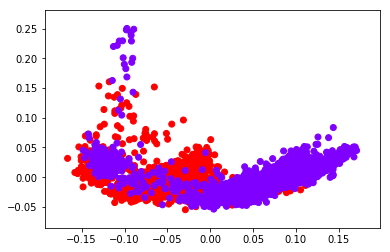

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_reduce)
fig, ax = plt.subplots(1)

ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y.values, cmap= 'rainbow')

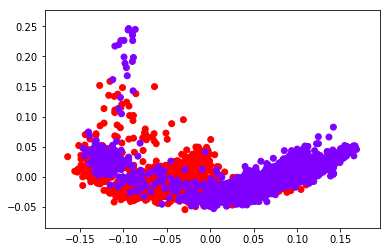

In [24]:
from sklearn.decomposition import KernelPCA
kernel = KernelPCA(kernel='rbf', gamma=0.5, n_components=2, random_state=42)
X_kernel = kernel.fit_transform(X_reduce)

fig, ax = plt.subplots(1)

ax.scatter(X_kernel[:, 0], X_kernel[:, 1], c=y.values, cmap= 'rainbow')

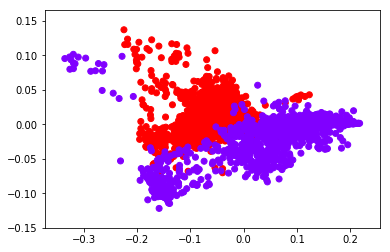

In [25]:
from sklearn.manifold import Isomap
X_iso = Isomap(n_neighbors=15, n_components=2).fit_transform(X_reduce)

fig, ax = plt.subplots(1)

ax.scatter(X_iso[:, 0], X_iso[:, 1], c=y.values, cmap= 'rainbow')

##### As we can see, Isomap, controversally to PCA methods, gives well separable representation. Use this two dimensional represenation to learning.


In [26]:
boost_iso = GradientBoostingClassifier(random_state = 42)
cross_val_model(boost_iso, X_iso, y, 0)

GradientBoostingClassifier: 0.944±0.029


In [27]:
forest_iso = RandomForestClassifier(random_state = 42)
cross_val_model(forest_iso, X_iso, y, 0)

RandomForestClassifier: 0.951±0.026


In [28]:
boost_iso.fit(X_iso, y)
forest_iso.fit(X_iso, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

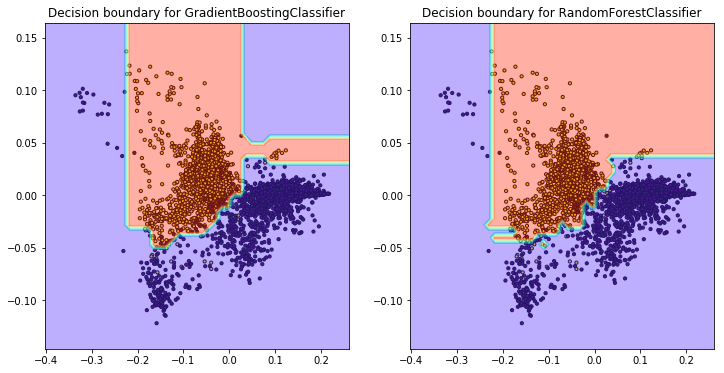

In [29]:
def expand(a, b, factor=0.2):
    """Make a wider interval defined by the endpoints."""
    return a - abs(a) * factor, b + abs(b) * factor

X_l, X_h = X_iso.min(axis=0), X_iso.max(axis=0)
xx0, xx1 = np.meshgrid(np.linspace(*expand(X_l[0], X_h[0]), num=51),
                       np.linspace(*expand(X_l[1], X_h[1]), num=51))

X_grid = np.c_[xx0.ravel(), xx1.ravel()]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for method, ax in zip([boost_iso, forest_iso], axes):
    Z = method.predict(X_grid).reshape(xx0.shape)
    ax.scatter(X_iso[:, 0], X_iso[:, 1], marker='o', c=y.values,
        s=10, edgecolor='k')
    ax.contourf(xx0, xx1, Z, alpha=0.4, cmap='rainbow')
    ax.set_title('Decision boundary for {}'.format(method.__class__.__name__))

##### Scores with ISO reduced by 0.01 for RF and Xgboost, but entirely ISO did not helped, so now tune parameters for 5-dimensional feature space

##### Tuning parameters:

##### Xgboost

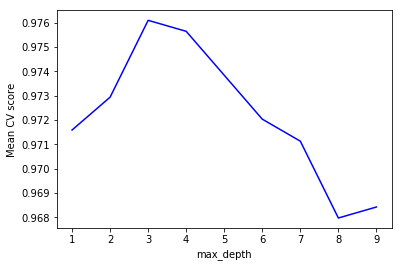

In [30]:
boost = GradientBoostingClassifier(random_state = 42)
prange=np.arange(1,10,1)
train_scores, cv_scores = validation_curve(boost, X_train, y_train ,param_name='max_depth',
                                              param_range=prange, scoring = 'accuracy')

plt.xlabel('max_depth')
plt.ylabel('Mean CV score')
plt.plot(prange, np.mean(cv_scores, axis=1), label="Cross-validation score",color="b")

In [31]:
boost = GradientBoostingClassifier(random_state = 0, max_depth = prange[np.argmax(np.mean(cv_scores, axis=1))])
parameters_b_new = {'learning_rate': np.arange(0.03,0.13, 0.01), 'n_estimators': np.arange(80, 160, 20)}
boosting_new = GridSearchCV(boost, param_grid = parameters_b_new, scoring='accuracy', verbose = 2, cv = 5)
boosting_new.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] learning_rate=0.03, n_estimators=80 .............................
[CV] .............. learning_rate=0.03, n_estimators=80, total=   0.2s
[CV] learning_rate=0.03, n_estimators=80 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............. learning_rate=0.03, n_estimators=80, total=   0.2s
[CV] learning_rate=0.03, n_estimators=80 .............................
[CV] .............. learning_rate=0.03, n_estimators=80, total=   0.2s
[CV] learning_rate=0.03, n_estimators=80 .............................
[CV] .............. learning_rate=0.03, n_estimators=80, total=   0.2s
[CV] learning_rate=0.03, n_estimators=80 .............................
[CV] .............. learning_rate=0.03, n_estimators=80, total=   0.2s
[CV] learning_rate=0.03, n_estimators=100 ............................
[CV] ............. learning_rate=0.03, n_estimators=100, total=   0.3s
[CV] learning_rate=0.03, n_estimators=100 ............................
[CV] ............. learning_rate=0.03, n_estimators=100, total=   0.3s
[CV] learning_rate=0.03, n_estimators=100 ............................
[CV] ............. learning_rate=0.03, n_estimators=100, total=   0.3s
[CV] learning_rate=0.03, n_estimators=100 ............................
[CV] .

[CV] ............. learning_rate=0.05, n_estimators=140, total=   0.4s
[CV] learning_rate=0.060000000000000005, n_estimators=80 .............
[CV]  learning_rate=0.060000000000000005, n_estimators=80, total=   0.2s
[CV] learning_rate=0.060000000000000005, n_estimators=80 .............
[CV]  learning_rate=0.060000000000000005, n_estimators=80, total=   0.2s
[CV] learning_rate=0.060000000000000005, n_estimators=80 .............
[CV]  learning_rate=0.060000000000000005, n_estimators=80, total=   0.2s
[CV] learning_rate=0.060000000000000005, n_estimators=80 .............
[CV]  learning_rate=0.060000000000000005, n_estimators=80, total=   0.2s
[CV] learning_rate=0.060000000000000005, n_estimators=80 .............
[CV]  learning_rate=0.060000000000000005, n_estimators=80, total=   0.2s
[CV] learning_rate=0.060000000000000005, n_estimators=100 ............
[CV]  learning_rate=0.060000000000000005, n_estimators=100, total=   0.3s
[CV] learning_rate=0.060000000000000005, n_estimators=100 ......

[CV]  learning_rate=0.08000000000000002, n_estimators=140, total=   0.4s
[CV] learning_rate=0.08000000000000002, n_estimators=140 .............
[CV]  learning_rate=0.08000000000000002, n_estimators=140, total=   0.4s
[CV] learning_rate=0.08000000000000002, n_estimators=140 .............
[CV]  learning_rate=0.08000000000000002, n_estimators=140, total=   0.4s
[CV] learning_rate=0.09000000000000001, n_estimators=80 ..............
[CV]  learning_rate=0.09000000000000001, n_estimators=80, total=   0.2s
[CV] learning_rate=0.09000000000000001, n_estimators=80 ..............
[CV]  learning_rate=0.09000000000000001, n_estimators=80, total=   0.2s
[CV] learning_rate=0.09000000000000001, n_estimators=80 ..............
[CV]  learning_rate=0.09000000000000001, n_estimators=80, total=   0.2s
[CV] learning_rate=0.09000000000000001, n_estimators=80 ..............
[CV]  learning_rate=0.09000000000000001, n_estimators=80, total=   0.2s
[CV] learning_rate=0.09000000000000001, n_estimators=80 ...........

[CV]  learning_rate=0.11000000000000001, n_estimators=140, total=   0.4s
[CV] learning_rate=0.11000000000000001, n_estimators=140 .............
[CV]  learning_rate=0.11000000000000001, n_estimators=140, total=   0.4s
[CV] learning_rate=0.11000000000000001, n_estimators=140 .............
[CV]  learning_rate=0.11000000000000001, n_estimators=140, total=   0.4s
[CV] learning_rate=0.11000000000000001, n_estimators=140 .............
[CV]  learning_rate=0.11000000000000001, n_estimators=140, total=   0.4s
[CV] learning_rate=0.11000000000000001, n_estimators=140 .............
[CV]  learning_rate=0.11000000000000001, n_estimators=140, total=   0.4s
[CV] learning_rate=0.12000000000000002, n_estimators=80 ..............
[CV]  learning_rate=0.12000000000000002, n_estimators=80, total=   0.2s
[CV] learning_rate=0.12000000000000002, n_estimators=80 ..............
[CV]  learning_rate=0.12000000000000002, n_estimators=80, total=   0.2s
[CV] learning_rate=0.12000000000000002, n_estimators=80 .........

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12]), 'n_estimators': array([ 80, 100, 120, 140])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [32]:
boosting_new.best_estimator_, boosting_new.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.12000000000000002, loss='deviance',
               max_depth=3, max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=140,
               presort='auto', random_state=0, subsample=1.0, verbose=0,
               warm_start=False), 0.9806044203879116)

In [33]:
y_predict_boost = boosting_new.predict(X_test)
print(accuracy_score(y_predict_boost, y_test))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_boost, y_test))
conf_mat

0.9758149316508938


,0,1
0,444,15
1,8,484


##### Random forest

In [34]:
forest = RandomForestClassifier(random_state = 42)
parameters_f_new = {'n_estimators': np.arange(20, 60, 5), 'max_depth': np.arange(2, 6, 1), 
                   'min_samples_leaf': np.arange(2, 6, 1)}
forest_new = GridSearchCV(forest, param_grid = parameters_f_new, scoring='accuracy', verbose = 0, cv = 5)
forest_new.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([20, 25, 30, 35, 40, 45, 50, 55]), 'max_depth': array([2, 3, 4, 5]), 'min_samples_leaf': array([2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [35]:
forest_new.best_estimator_, forest_new.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=5, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 0.9765448804691024)

In [36]:
y_predict_fr = forest_new.predict(X_test)
print(accuracy_score(y_predict_fr, y_test))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_fr, y_test))
conf_mat

0.9779179810725552


,0,1
0,441,10
1,11,489


##### Stacked model

In [37]:
svm = SVC(random_state = 42, probability=True)
parameters_svm_new = {'C': np.arange(0.1, 1.2, 0.1)}
svm_new = GridSearchCV(svm, param_grid = parameters_svm_new, scoring='accuracy', verbose = 0, cv = 5)
svm_new.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [38]:
y_predict = svm_new.predict(X_test)
print(accuracy_score(y_predict, y_test))
conf_mat = pd.DataFrame(confusion_matrix(y_predict, y_test))
conf_mat

0.7181913774973712


,0,1
0,319,135
1,133,364


In [39]:
combo = pd.DataFrame({'forest': forest_new.predict_proba(X_test)[:, 1], 
                      'svm': svm_new.predict_proba(X_test)[:, 1], 
                      'boost': boosting_new.predict_proba(X_test)[:, 1]})
cross_val_model(boost, combo, y_test, 0)

def cross_val_model_new(model, X_reduce, y, verbose=2):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, X_reduce, y, cv=cv, verbose=verbose, scoring='accuracy')
    return (np.mean(scores))

GradientBoostingClassifier: 0.967±0.007


#### Results

In [40]:
print('Choosen metric is accuracy')
print('Neural network from the article: {:.3f}'.format(np.mean(scores), np.std(scores)))
print('Random forest: {:.3f}'.format(accuracy_score(y_test, y_predict_fr)))
print('Xgboost: {:.3f}'.format(accuracy_score(y_test, y_predict_boost)))
print('SVM: {:.3f}'.format(accuracy_score(y_test, y_predict)))
print('Stacked model: {:.3f}'.format(cross_val_model_new(boost, combo, y_test, 0)))

Choosen metric is accuracy
Neural network from the article: 0.966
Random forest: 0.978
Xgboost: 0.976
SVM: 0.718
Stacked model: 0.967


##### Score in the article is true indeed, we have replicated their experiment and got the same result (it was stated as 0.967)
##### However, other ML algorithm as Xgboost, Random Forest worked better (!), so we got better results with simpler models